In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import os

%matplotlib inline

In [2]:
curdir = os.getcwd()

In [3]:

os.chdir("../../core/")
import GT_helper_functions as hf
import GT_load_data as data

os.chdir(curdir)

In [4]:
fullIndex = data.munisGT[(data.munisGT.municode != 0) & data.munisGT.deptocode.notna()]\
.assign(deptocode = lambda x: x.deptocode.astype(int)).groupby(["deptocode", "municode"]).apply(len).index

In [6]:
def makeFullIndex(dfyears):
    indexList = fullIndex.to_list()
    newIndex = []
    print(dfyears.index.names)
    # En caso de que no haya nivel de quarter, introducirlo,
    if "quarter" not in dfyears.index.names:
        print("imputing quarter index level")
        for year in dfyears.index.levels[0]:
            for q in [1,2,3,4]:
                newIndex.extend([(year, x[0], x[1], q) for x in indexList])

        reindexeddf =  dfyears.reindex(pd.MultiIndex.from_tuples(newIndex, names = ["year", "department", "municipality", "quarter"]))
    
        return reindexeddf.reorder_levels(["year", "quarter", "department", "municipality"])
    else:
        for year in dfyears.index.levels[0]:
            for q in [1,2,3,4]:
                newIndex.extend([(year, q, x[0], x[1]) for x in indexList])

        reindexeddf =  dfyears.reindex(pd.MultiIndex.from_tuples(newIndex, names = ["year", "quarter", "department", "municipality"]))
        return reindexeddf

In [7]:
def tryfun(f):
    def wrapper(i):
        try:
            return f(i)
        except:
            return np.NaN
    return wrapper

# Outputs


In [8]:
notifs = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Notificaciones TB/GTM - TB all notifications 2012-Sep2018.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,8,9,11,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,72,74,78,79,80,81,83,84,85,87,89,90,91,93,94,98,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
notifs.loc[notifs.COD_MUNI == 1422, "COD_MUNI"] = 1420

In [10]:
notifs["year"] = np.floor(notifs.YearMonth/100).astype(int)
notifs["quarter"] = (np.floor(( (notifs.YearMonth%100) - 1) / 3) + 1).astype(int)

In [11]:
notifs.quarter.value_counts()

2    8471
3    7544
1    7537
4    6255
Name: quarter, dtype: int64

In [12]:
notifs.COD_MUNI.isna().sum()

1

In [13]:
notifs = notifs[notifs.COD_MUNI.notna()]\
.assign(municipality = lambda x: x.apply(lambda y: y.COD_MUNI if y.COD_MUNI!=0 else (y.COD_DEPT*100+1), axis=1).astype(int) )\
.assign(department = lambda y: y.apply(lambda x: (np.floor(x.COD_MUNI/100)).astype(int) if x.COD_MUNI!=0 else x.COD_DEPT, axis=1).astype(int) )\

In [17]:
casesNotif = notifs[(notifs.year<=2018) & notifs.COD_MUNI.notna()]\
.assign(year=lambda x: x.year.astype(int))\
.assign(quarter = lambda x: x.quarter.astype(int))\
.groupby(["year", "quarter", "department", "municipality"]).apply(len)

In [18]:
casesNotif = casesNotif[casesNotif.index.get_level_values(1)!=0].rename("Cases Notified_value_m_quarterly").fillna(0)

In [19]:
casesNotif.head()

year  quarter  department  municipality
2012  1        1           101             56
                           102              2
                           103              3
                           106              8
                           107              2
Name: Cases Notified_value_m_quarterly, dtype: int64

In [20]:
extraM2017 = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Extramuros2017.csv", index_col=0)

In [21]:
acfcases = extraM2017[extraM2017.Year.notna()].assign(municipality = lambda x: x.MuniCode.astype(int)).assign(year = lambda x: x.Year.astype(int)).\
assign(department = lambda x: x.DeptoCode.astype(int)).groupby(["year", "department", "municipality"])["bacteriologicos.extramuros"].sum()
acfcases = acfcases.rename("Additional Cases Detected via ACF_value_m_yearly").fillna(0)

In [22]:
# Extramuros 2017-2018
# datos adicionales por departamento obtenidos del PNTB
extraMurosData = pd.read_excel("../../../Outcome Measurement Data/TUBERCULOSIS/TB-Extramuros-2017-2018.xlsx")

In [23]:
extraMurosData.Variable.unique()

array(['Número de sintomáticos respiratorios detectados ',
       'Número de sintomáticos respiratorios examinados',
       'Número de muestras para BK recolectadas y enviadas a laboratorio',
       'Número de muestras para Xpert y cultivo recolectadas y enviadas a laboratorio',
       'Número de casos TB todas sus formas (nuevos y recaídas) detectados',
       'Número de casos nuevos TB todas sus formas detectados',
       'Número de casos nuevos bacteriologicamente confirmados detectados',
       'Cantidad  de niños <de 5 años referidos para evaluación a través de ruta diagnostica para descartar tuberculosis',
       'Cantidad de niños < de 5 años diagnosticados con TB (de los referidos)',
       'Cantidad de niños < de 5 años que reciben quimioprofilaxis (de los referidos)'],
      dtype=object)

In [24]:
acfcases2 = \
extraMurosData[extraMurosData.Variable.isin(['Número de casos nuevos TB todas sus formas detectados'])]\
[["Year", "Department", "Extramuros"]].groupby(["Year", "Department"]).Extramuros.sum()\
.rename("Additional Cases Detected via ACF_value_d_yearly").rename_axis(index={ "Year": "year", "Department": "department"})


In [25]:
# Cases Started on Treatment_value
# MDR Cases Started Treatment_value

cohortes = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/GTM - Tx cohort data 2012-2017.csv")

In [26]:
mapCohortTrimestre = {
    "I TRIMESTRE": 1,
    "II TRIMESTRE": 2,
    "III TRIMESTRE": 3,
    "IV TRIMESTRE": 4
}

In [27]:
cohortes["quarter"] = cohortes.col_name.map(tryfun(mapCohortTrimestre.get))

In [28]:
cohortes.head()

,Unnamed: 0,col_name,deptocode,row_name,row_name_B,table,value,year,quarter
0,0,I TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Bact Conf,474.0,2017,1.0
1,1,II TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Bact Conf,511.0,2017,2.0
2,2,III TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Bact Conf,497.0,2017,3.0
3,3,IV TRIMESTRE,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Bact Conf,474.0,2017,4.0
4,4,TOTAL,0,CURADOS,COMPLETED TREATMENT,Nuevos Pulmonares Bact Conf,1956.0,2017,NaN


In [29]:
pivot_cohortes = cohortes[
       (cohortes.quarter.notna()) & 
       ((cohortes.year <=2016) & cohortes.table.isin([
                "Nuevos Pulmonares BK+", 
                "Nuevos Pulmonares BK-", 
                "Nuevos Pediatricos", 
                "Nuevos Extrapulmonares", 
                "Nuevos TB/VIH", "Retratamiento"
            ]) |
       # 2017
       ((cohortes.year == 2017) & cohortes.table.isin([
               "Nuevos Pulmonares Bact Conf", 
               "Nuevos Pulmonares pediatricos Bact Conf", 
               "Nuevos Pulmonares Dx Clinico",
               "Nuevos Extrapulmonares Bact Conf", 
               "Nuevos Extrapulmonares Dx Clinico"
            ]))
       ) &
       (cohortes.deptocode!=0)].\
    groupby(["year", "quarter", "deptocode", "row_name_B"]).value.sum().unstack(3)

In [30]:
initiatedTx = pivot_cohortes.sum(axis=1)

In [31]:
initiatedTx = initiatedTx.rename_axis(index = {"deptocode": "department" }).rename("Cases Started on Treatment_value_d_quarterly")

In [32]:
notifs["Tx"] = notifs.FECHAINICIOTX.map(lambda x: len(str(x))>4)

In [33]:
notifs.groupby("YEAR")["Tx"].sum()

YEAR
2012    2368.0
2013    2394.0
2014    2644.0
2015    2500.0
2016    2758.0
2017    3990.0
2018    3003.0
Name: Tx, dtype: float64

In [34]:
# Por trimestre
initiatedTx.reset_index().groupby("year")["Cases Started on Treatment_value_d_quarterly"].sum()

year
2012    3647.0
2013    3472.0
2014    3261.0
2015    3449.0
2016    3286.0
2017    3113.0
Name: Cases Started on Treatment_value_d_quarterly, dtype: float64

In [35]:
# Arriba se muestra que los conteos de las cohortes no encajan con los conteos de los que reciben tratamiento según las notificaciones.
# Se podría deber a que hay personas que reciben tratamiento pero abandonan antes de que se registren en las cohortes
# O podría ser que fueron notificados en un año pero se integraron en la cohorte en el siguiente año. 
# Sin embargo, las notificaciones muestran conteos muy bajos 

In [36]:
initiatedTx2 = initiatedTx.reindex(casesNotif.index).fillna(0)

In [37]:
# Reindex is not bad in this case?? - 4 missing cases
initiatedTx.sum(), initiatedTx2.groupby([initiatedTx2.index.get_level_values(0), 
                                         initiatedTx2.index.get_level_values(1),
                                         initiatedTx2.index.get_level_values(2)]).first().sum()

(20228.0, 20224.0)

In [38]:
tbquimio = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Notificaciones TB/GTM - TB quimio 2012-Sep2018.csv",
                     index_col = 0, low_memory = False)

In [39]:
tbquimio.head()

,NOMBRES,DIRECCION,MUNICIPIO,DEPARTAMENTO,SERVICIODESALUD,SEXO,EDAD,RANGOEDAD,PESOLBS,PESOKG,...,CONTROL7_GX,OBSERVACIONES,PRIORIZACION,PESOLB,NotificationDate,YearMonth_,DEPTO_CORRECTED,i,COD_DEPT,COD_MUNI
1,NaN,NaN,GRANADOS,BAJA VERAPAZ,"CS, GRANADOS",f,1.0,000 - 004,13.4,6.0909090909090908,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,165,15,1505
2,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",f,8.0,005 - 009,50.8,23.090909090909086,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,167,15,1501
3,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",m,5.0,005 - 009,35,15.909090909090908,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,168,15,1501
4,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",m,6.0,005 - 009,36,16.363636363636363,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,169,15,1501
5,NaN,NaN,SALAMA,BAJA VERAPAZ,"PS, LLANO GRANDE",m,2.0,000 - 004,24.8,11.272727272727272,...,NaN,NaN,NaN,NaN,NaN,NaN,BAJA VERAPAZ,170,15,1501


In [40]:
tbquimio["year"] = np.floor(tbquimio.YearMonth/100).astype(int)
tbquimio["quarter"] = (np.floor(( (tbquimio.YearMonth%100) - 1) / 3) + 1).astype(int)

In [41]:
plhivipt= tbquimio[tbquimio.VIH=="Reactive"].assign(department = lambda x: np.floor(x.COD_MUNI/100))\
.groupby(["year", "quarter", "department", "COD_MUNI"]).apply(len)

In [42]:
plhivipt.index.levels

FrozenList([[2012, 2013, 2014, 2015, 2016], [1, 2, 3, 4], [0.0, 1.0, 3.0, 5.0, 8.0, 9.0, 11.0, 12.0, 22.0], [0, 101, 108, 116, 306, 501, 503, 506, 511, 805, 902, 920, 924, 1102, 1105, 1106, 1108, 1109, 1215, 1218, 1225, 2205, 2207]])

In [43]:
plhivipt = plhivipt.rename("PLHIV started on IPT_value_m_quarterly").fillna(0)\
.rename_axis(index={"Year": "date", "COD_MUNI": "municipality"}) #.reindex(casesNotif.index)

In [44]:
# This is only contacts in notifications database. I am not sure if its ok.

In [45]:
childipt= tbquimio[(tbquimio.year<=2018) & (tbquimio.EDAD <= 5)].assign(department = lambda x: np.floor(x.COD_MUNI/100))\
.groupby(["year", "quarter", "department", "COD_MUNI"]).apply(len).rename("Children in Contact with TB Started IPT_value_m_quarterly")

In [46]:
childipt = childipt.rename_axis(index={"COD_MUNI": "municipality"}) #.reindex(casesNotif.index)
childipt.head()

year  quarter  department  municipality
2012  1        1.0         101             4
                           102             1
                           108             5
                           110             5
                           115             4
Name: Children in Contact with TB Started IPT_value_m_quarterly, dtype: int64

In [47]:
# Cases Notified in Prisons_value
pplcases = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Prisoners/PPL-conteos-2014-2017.csv", index_col=0)

In [48]:
pplcases.head()

,YEAR,municipio,n
0,2014,101,17
1,2014,113,5
2,2014,501,44
3,2014,601,1
4,2014,901,4


In [49]:
pplcases = pplcases.assign(department = lambda x : np.floor(x.municipio/100))\
.assign(municipio = lambda y: y.municipio.astype(int)).rename(columns={
    "n": "Cases Notified in Prisons_value_m_yearly", 
    "YEAR": "year", 
    "municipio": "municipality"
})\
.set_index(["year", "department", "municipality"])

In [50]:
pplcases = makeFullIndex( pplcases)

['year', 'department', 'municipality']
imputing quarter index level


In [51]:
pplcases.head()

Cases Notified in Prisons_value_m_yearly
year quarter department municipality                                          
2014 1       1          101                                               17.0
                        102                                                NaN
                        103                                                NaN
                        104                                                NaN
                        105                                                NaN

In [52]:
ppldata = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Prisoners/tb-ppl-2014-2017.csv")

In [53]:
ppldata["TXDATE"] = pd.to_datetime(ppldata.TXDATE, errors="coerce")

In [54]:
# Sólo una persona no recibió tratamiento.
print(ppldata.TXDATE.isna().sum())
ppldata = ppldata[ppldata.TXDATE.notna() & (ppldata.TXDATE.map(lambda x: x.year > 2012))]

1


In [55]:
ppldata["year"] = ppldata.TXDATE.map(tryfun(lambda x: x.year)).astype(int)
ppldata["quarter"] = ppldata.TXDATE.map(tryfun(lambda x: np.floor((x.month-1) / 3 + 1)) ).astype(int)
ppldata.quarter.value_counts(dropna=False)

3    143
1    130
2    122
4    120
Name: quarter, dtype: int64

In [56]:
ppltx = ppldata[ppldata.TXDATE.notna()].assign(department = lambda x: np.floor(x.municode.astype(int)/100).astype(int) )\
.groupby(["year", "quarter", "department" , "municode"]).apply(len)\
.rename_axis(index={"municode": "municipality"})\
.rename("Cases Started on Treatment in Prisons_value_m_quarterly")

In [57]:
ppltx = ppltx[ppltx.index.get_level_values("year")>2012]

In [320]:
ppltx

year  quarter  department  municipality
2014  1        1           101              6
                           113              2
               5           501             14
               9           901              3
               18          1801             2
               19          1901             1
      2        1           101              5
                           113              2
               5           501              9
               6           601              1
               18          1801             3
               19          1901             1
      3        1           101              5
                           113              1
               5           501             12
               9           901              1
               18          1801             4
               19          1901             2
      4        1           101              1
               5           501              9
               18          1801         

In [321]:
# Lets see in the cohort data:
hivyear_A = cohortes[(cohortes.quarter.notna()) & 
       (cohortes.table.isin([
                   "Nuevos TB/VIH",  # year <= 2016
                   "Nuevos Pulmonares TB/VIH Bact Conf", "Nuevos Pulmonares TB/VIH Dx Clinico" #2017
                ])) &
       (cohortes.deptocode==0)].groupby(["year"]).value.sum()
hivyear_A

year
2012    269.0
2013    226.0
2014    197.0
2015    173.0
2016    163.0
2017    218.0
Name: value, dtype: float64

In [322]:
# Now with notifications data:
hivyear_B = notifs.groupby(["year", "quarter", "VIH"]).apply(len).unstack(2)["Reactive"]
hivyear_B = hivyear_B.groupby(hivyear_B.index.get_level_values("year")).sum()
hivyear_B

year
2012    290.0
2013    277.0
2014    263.0
2015    200.0
2016    259.0
2017    241.0
2018    157.0
Name: Reactive, dtype: float64

In [323]:
# HIV counts per year, from cohort and from notifications seems to be worse than in previous years
# This may be interpreted as the percentage of HIV cases that received treatment.
hivyear_A/hivyear_B

year
2012    0.927586
2013    0.815884
2014    0.749049
2015    0.865000
2016    0.629344
2017    0.904564
2018         NaN
dtype: float64

In [512]:
# The actual data to integrate into the tables:
# HIV/TB Cases Notified_value

hivcases = notifs[(notifs.VIH == "Reactive") & (notifs.Year<=2018) & notifs.COD_MUNI.notna()]\
.assign(department = lambda x: (np.floor(x.municipality/100)).astype(int) ).groupby(["year", "quarter", "department", "municipality"]).apply(len)\
.rename("HIV/TB Cases Notified_value_m_quarterly")

In [325]:
# Now looking at MDR data in notifications:
notifs[notifs.DBCATEGORY=="MDR"].YEAR.value_counts()

2017    95
2018    28
Name: YEAR, dtype: int64

In [326]:
# There is actually a MDR table with all available cohort data:
mdrtb = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/GTM - TB MDR Cohort Data 2014-2016.csv")

In [327]:
mdrtb.head()

,Unnamed: 0,Age,BD_ID,DAS,DateBk_1,DateCulture_1,DateCulture_10,DateCulture_11,DateCulture_12,DateCulture_13,...,TxDate_,TxDate_Year,DxDate_,DxDate_Year,ExitDate_,ExitDate_Year,PDSDate_,PDSDate_Year,GxDate_,deptocode
0,0,23.0,MDR14-16,MEXICO,2014-01-21 00:00:00,2014-04-25 00:00:00,2014-11-06 00:00:00,NaN,2015-01-20 00:00:00,NaN,...,2014-01-30 00:00:00,2014.0,NaN,NaN,2014-05-30 00:00:00,2014.0,2014-04-30 00:00:00,2014.0,NaN,NaN
1,1,48.0,MDR14-16,Suchitepequez,2014-02-03 00:00:00,2014-05-11 00:00:00,NaN,2015-01-07 00:00:00,NaN,2015-03-05 00:00:00,...,2014-02-10 00:00:00,2014.0,NaN,NaN,2014-06-17 00:00:00,2014.0,2013-06-05 00:00:00,2013.0,NaN,10.0
2,2,19.0,MDR14-16,Guatemala Central,2014-02-05 00:00:00,2014-10-01 00:00:00,NaN,NaN,NaN,2015-07-25 00:00:00,...,10/02/2014 Y 26/06/14,NaN,NaN,NaN,2014-02-25 00:00:00,2014.0,NaN,NaN,NaN,1.0
3,3,22.0,MDR14-16,Retalhuleu,2014-02-06 00:00:00,2014-05-11 00:00:00,NaN,2015-01-13 00:00:00,NaN,NaN,...,2014-02-10 00:00:00,2014.0,NaN,NaN,2014-06-17 00:00:00,2014.0,2013-10-29 00:00:00,2013.0,NaN,11.0
4,4,79.0,MDR14-16,Suchitepequez,2014-02-05 00:00:00,2014-05-11 00:00:00,NaN,2015-01-07 00:00:00,NaN,2015-03-05 00:00:00,...,2014-02-10 00:00:00,2014.0,NaN,NaN,2014-06-17 00:00:00,2014.0,2013-06-11 00:00:00,2013.0,NaN,10.0


In [328]:
# How many bad tx initiation date values are there?
mdrtb.groupby("Year").apply(lambda x: x.TxDate_Year.isna().sum())

Year
14     1
15     6
16    22
dtype: int64

In [329]:
# MDR Cases Notified_value
# MDR Cases Started Treatment_value

mdrcases = mdrtb[mdrtb.deptocode.notna()]\
.assign(year = lambda x: x.Year+2000).assign(department = lambda x: x.deptocode.astype(int))\
.groupby(["year","department"]).apply(len).rename("MDR Cases Notified_value_d_yearly")
    
mdrtx = mdrtb[mdrtb.deptocode.notna() & (mdrtb.TxDate_Year.notna())]\
.assign(year = lambda x: x.TxDate_Year.map(tryfun(int)) ).assign(department = lambda x: x.deptocode.astype(int))\
.groupby(["year","department"]).apply(len).rename("MDR Cases Started Treatment_value_d_yearly")

mdrtx = mdrtx[mdrtx.index.get_level_values(0)>2012]

In [330]:
mdrtx.index = mdrtx.index.remove_unused_levels()

In [331]:
mdrtx = makeFullIndex(mdrtx)

['year', 'department']
imputing quarter index level


In [559]:
outputs = pd.merge(makeFullIndex(casesNotif) , makeFullIndex(acfcases2), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(initiatedTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(plhivipt), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(childipt), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(pplcases), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(ppltx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(hivcases), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(mdrcases), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(mdrtx), left_index=True, right_index=True, how="outer")\

['year', 'quarter', 'department', 'municipality']
['year', 'department']
imputing quarter index level
['year', 'quarter', 'department']
['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']
['year', 'department']
imputing quarter index level
['year', 'quarter', 'department', 'municipality']


In [560]:
outputs[(outputs.index.get_level_values("municipality") == 0) | 
       (outputs.index.get_level_values("municipality") == "") | 
       (outputs.index.get_level_values("municipality") == None)]

,,,,Cases Notified_value_m_quarterly,Additional Cases Detected via ACF_value_d_yearly,Cases Started on Treatment_value_d_quarterly,PLHIV started on IPT_value_m_quarterly,Children in Contact with TB Started IPT_value_m_quarterly,Cases Notified in Prisons_value_m_yearly,Cases Started on Treatment in Prisons_value_m_quarterly,HIV/TB Cases Notified_value_m_quarterly,MDR Cases Notified_value_d_yearly,MDR Cases Started Treatment_value_d_yearly
year,quarter,department,municipality,,,,,,,,,,


In [561]:
# outputs

In [562]:
outputs.to_csv("../../../Impact Evaluation/TB/outputs.csv")

In [563]:
outputs.groupby(["department", "year"]).first()["MDR Cases Started Treatment_value_d_yearly"].sum()

124.0

# Activities

Not available: 
* Tests Conducted_value
* Active Case Finding Missions Conducted_value
* Prisoners Screened_value


In [235]:
# Tests Conducted_value
sicoinRM = pd.read_csv("../../../Resource Tracking/SICOIN GT/IGRC02_Quarters_PCE_Ejecucion_Fisica.csv")

In [236]:
sicoinTB = sicoinRM[(sicoinRM.Programa == "17-PREVENCIÓN Y CONTROL DE LA TUBERCULOSIS") ]

In [207]:
distrMeds = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/Distribución Medicamentos TB/GTM-TB-distribution-2013-2018.csv", index_col=0)

In [338]:
distrMeds.head()

,Program,Product,Supplier,Department,Year,Month,Amount,Recipient,MG,Medicine,ML,code_dept,drug,class,quarter
0,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,1,0.0,DAS,300,ISONIAZIDA,0.0,16,ISONIAZIDA,FIRSTLINE,1
1,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,2,2740.0,DAS,300,ISONIAZIDA,0.0,16,ISONIAZIDA,FIRSTLINE,1
2,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,3,0.0,DAS,300,ISONIAZIDA,0.0,16,ISONIAZIDA,FIRSTLINE,1
3,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,4,0.0,DAS,300,ISONIAZIDA,0.0,16,ISONIAZIDA,FIRSTLINE,2
4,PROGRAMA NACIONAL DE TUBERCULOSIS,"ISONIAZIDA, TABLETA DE 300 MG.","RESCO, SOCIEDAD ANONIMA/ OPS",ALTA VERAPAZ,2013,5,3376.0,DAS,300,ISONIAZIDA,0.0,16,ISONIAZIDA,FIRSTLINE,2


In [341]:
drugclass = pd.DataFrame(data = [
    ["RIFAMPICINA", "FIRSTLINE"],
    ["ISONIAZIDA", "FIRSTLINE"],
    ["ETHIONAMIDA", "SECONDLINE"],
    ["PIRAZINAMIDA", "FIRSTLINE"],
    ["TUBERCULINA", "DX"],
    ["KANAMICINA", "SECONDLINE"],
    ["LEVOFLOXACINA", "SECONDLINE"],
    ["ETAMBUTOL", "FIRSTLINE"],
    ["CLOFAZIMINE", "SECONDLINE"],
    ["AMOXICILINA/ACIDO CLAVULANICO", "MDR"],
    ["CICLOCERINA", "SECONDLINE"],
    ["ESTREPTOMICINA", "FIRSTLINE"],
    ["MOXIFLOXACINA", "SECONDLINE"],
    ["ACIDO PARAAMINOSALICILICO", "SECONDLINE"],
    ["CAPREOMICINA", "SECONDLINE"],
    ["LINEZOLID", "SECONDLINE"],
    ["IMIPENEM/CILASTATINA", "MDR"]
], columns= ["drug", "class"])

distrMeds = distrMeds.merge(drugclass, left_on="Medicine", right_on = "drug", how="outer")

In [342]:
distrMeds["class"].value_counts()

FIRSTLINE     14040
SECONDLINE    12960
DX             2160
MDR            2160
Name: class, dtype: int64

In [343]:
distrMeds["quarter"] = distrMeds.Month.map(lambda x: np.floor((x-1)/3)+1 ).astype(int)

In [344]:
meds = distrMeds.groupby(["Year", "quarter", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "year", "code_dept": "department"})\
.rename("Total Drugs Distributed_value_d_quarterly")

In [345]:
pd.options.display.max_rows = 100

In [346]:
distrMeds.Medicine.unique()

array(['ISONIAZIDA', 'RIFAMPICINA', 'PIRAZINAMIDA', 'ETAMBUTOL',
       'ESTREPTOMICINA', 'KANAMICINA', 'CICLOCERINA', 'ETHIONAMIDA',
       'LEVOFLOXACINA', 'TUBERCULINA', 'CLOFAZIMINE',
       'AMOXICILINA/ACIDO CLAVULANICO', 'MOXIFLOXACINA', 'CICLOSERINA',
       'CAPREOMICINA', 'ACIDO PARAAMINOSALICILICO', 'LINEZOLID',
       'IMIPENEM/CILASTATINA'], dtype=object)

In [347]:
meds1 = distrMeds[(distrMeds["class"] == "FIRSTLINE") & (distrMeds.Medicine != "ISONIAZIDA")].groupby(["Year", "quarter", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "year", "code_dept": "department"})\
.rename("Total First Line Drugs _minusIsonizide_ Distributed_value_d_quarterly")
medsMDR = distrMeds[distrMeds["class"] == "MDR"].groupby(["Year", "quarter", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "year", "code_dept": "department"})\
.rename("Total MDR Drugs Distributed_value_d_quarterly")
medsDx = distrMeds[distrMeds["class"] == "DX"].groupby(["Year", "quarter", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "year", "code_dept": "department"})\
.rename("Total Tuberculine Distributed_value_d_quarterly")

In [348]:
# Isoniazid Distributed_value
isod = distrMeds[distrMeds.Medicine == "ISONIAZIDA"].groupby(["Year", "quarter", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "year", "code_dept": "department"})\
.rename("Isoniazid Distributed_value_d_quarterly")

In [349]:
# PLHIV Screened for TB_value
hivtb = \
sicoinRM[(sicoinRM.Programa == "16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA") &
sicoinRM.Resultado.isin(
       ['6.0-Paciente VIH positivo, con prueba diagnóstica de tuberculosis',
       '6.0-Pacientes VIH positivos, con prueba diagnostica de Tuberculosis']
) & (sicoinRM.LugarEjecutado.notna())].assign(year = lambda x: x.Year, quarter= lambda x: x.Trimestre, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["year", "quarter", "department", "municipality"]).LugarEjecutado.sum()\
.rename("PLHIV Screened for TB_value_m_quarterly")

In [350]:
hivtb.idxmax()

(2014, 4, 7, 713)

In [351]:
# TB Patients Tested for HIV_value
tbhivTx = sicoinRM[(sicoinRM.Programa == "17-PREVENCIÓN Y CONTROL DE LA TUBERCULOSIS") &
sicoinRM.Resultado.isin(
       ['7.0-Persona con diagnóstico de tuberculosis con prueba diagnóstica de VIH',
       '7.0-Casos de Tuberculosis con prueba diagnóstica de VIH']
) & (sicoinRM.LugarEjecutado.notna())].assign(year = lambda x: x.Year, quarter = lambda x: x.Trimestre, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["year", "quarter", "department", "municipality"]).LugarEjecutado.sum()\
.rename("TB Patients Tested for HIV_value_m_quarterly")

In [352]:
# Number of Cases Screened for MDR_value
mdrSx = sicoinRM[(sicoinRM.Programa == "17-PREVENCIÓN Y CONTROL DE LA TUBERCULOSIS") &
sicoinRM.Resultado.isin(
       ['9.0-Persona con diagnóstico de fracasos al tratamiento de tuberculosis con prueba diagnóstica a TB-MDR (tuberculosis multidrogo resistente)',
        '9.0-Casos de fracasos a tratamiento de Tuberculosis con prueba diagnóstica a TB-MDR']
) & (sicoinRM.LugarEjecutado.notna())].assign(year = lambda x: x.Year, quarter = lambda x: x.Trimestre, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["year", "quarter", "department", "municipality"]).LugarEjecutado.sum()\
.rename("Number of Cases Screened for MDR_value_m_quarterly")

In [353]:
cohortsExtraD = pd.read_csv("../../../Outcome Measurement Data/TUBERCULOSIS/COHORTES/GTM - Tx Cohort Data - Extra tables.csv")

In [354]:
cohortsExtraD.columns

Index(['year', 'table', 'das', 'column', 'value', 'col_index', 'deptocode'], dtype='object')

In [355]:
cohortsExtraD.table.unique()

array(['SR', 'Nuevos BK+', 'Nuevos BK-', 'Nuevos Extrapulmonares',
       'Pediatricos', 'TB/VIH Iniciaron TARV', 'TB/VIH Tx Preventivo',
       'SR Extension Cobertura', 'Nuevos BK+ Extension Cobertura',
       'Tamizaje Contactos', 'Contactos con TB', 'Contactos Tx 0-10a',
       'Centros de salud EATB', 'Puestos de salud EATB',
       'Hospitales EATB', 'Jurisdicciones EATB', 'Otros EATB',
       'Laboratorios', 'Laboratorios baciloscopias',
       'Laboratorios cultivo', 'Laboratorios sensibilidad drogas',
       'Contactos Tx 0-5a', 'VIH Tx Preventivo', 'ExtCob EATB'],
      dtype=object)

In [356]:
cohortes.table.unique()

array(['Nuevos Pulmonares Bact Conf', 'Nuevos Pulmonares Adultos BK+',
       'Nuevos Pulmonares Adultos Genexpert',
       'Nuevos Pulmonares Adultos Cultivo',
       'Nuevos Pulmonares pediatricos Bact Conf',
       'Nuevos Pulmonares pediatricos BK+',
       'Nuevos Pulmonares pediatricos Cultivo',
       'Nuevos Pulmonares pediatricos Genexpert',
       'Nuevos Extrapulmonares Bact Conf',
       'Nuevos Extrapulmonares Adultos Bact Conf',
       'Nuevos Extrapulmonares pediatricos Bact Conf',
       'Nuevos Pulmonares Dx Clinico',
       'Nuevos Pulmonares Dx Clinico Adultos',
       'Nuevos Extrapulmonares Dx Clinico',
       'Nuevos Extrapulmonares Dx Clinico Adultos',
       'Nuevos Extrapulmonares Dx Clinico pediatricos',
       'Nuevos Pulmonares TB/VIH Bact Conf',
       'Nuevos Pulmonares TB/VIH BK+',
       'Nuevos Pulmonares TB/VIH Genexpert',
       'Nuevos Pulmonares TB/VIH Cultivo',
       'Nuevos Pulmonares TB/VIH Dx Clinico', 'Retratamiento Bact Conf',
       'Retrata

In [357]:
cohortes[cohortes.table.isin(['MDR sensitivity tests on new','MDR test on previously treated']) & 
        (cohortes.deptocode==0)]

,Unnamed: 0,col_name,deptocode,row_name,row_name_B,table,value,year,quarter
819,819,NaN,0,NaN,NaN,MDR sensitivity tests on new,22.0,2017,NaN
821,821,NaN,0,NaN,NaN,MDR test on previously treated,20.0,2017,NaN
25638,25638,NaN,0,NaN,NaN,MDR sensitivity tests on new,116.0,2016,NaN
25640,25640,NaN,0,NaN,NaN,MDR test on previously treated,65.0,2016,NaN
45432,45432,NaN,0,NaN,NaN,MDR sensitivity tests on new,210.0,2015,NaN
45434,45434,NaN,0,NaN,NaN,MDR test on previously treated,94.0,2015,NaN
63288,63288,NaN,0,NaN,NaN,MDR sensitivity tests on new,22.0,2014,NaN
63290,63290,NaN,0,NaN,NaN,MDR test on previously treated,0.0,2014,NaN
86424,86424,NaN,0,NaN,NaN,MDR sensitivity tests on new,67.0,2013,NaN
86426,86426,NaN,0,NaN,NaN,MDR test on previously treated,72.0,2013,NaN


In [358]:
mdrSx = cohortes[cohortes.table.isin(['MDR sensitivity tests on new','MDR test on previously treated']) & 
        (cohortes.deptocode!=0)].groupby(["year", "deptocode"]).value.sum()\
            .rename_axis(index={ "year": "year", "deptocode": "department" })\
            .rename("Number of Cases Screened for MDR_value_d_yearly")

In [359]:
mdrSx.tail()

year  department
2017  18            8.0
      19            0.0
      20            0.0
      21            0.0
      22            0.0
Name: Number of Cases Screened for MDR_value_d_yearly, dtype: float64

In [360]:
# Second Line Drugs Distributed_value

In [361]:
# De acuerdo al manual de tb drogoresistente del programa
segundaLinea = [
    'LEVOFLOXACINA',
    'CAPREOMICINA',
    'MOXIFLOXACINA',
    'KANAMICINA',
    'ESTREPTOMICINA',
    'ETHIONAMIDA',
    'CICLOCERINA',
    'CICLOSERINA',
    'LINEZOLID',
    'CLOFAZIMINE',
    'PIRAZINAMIDA',
    'ETAMBUTOL',
    'ACIDO PARAAMINOSALICILICO',
    'IMIPENEM/CILASTATINA',
    'AMOXICILINA/ACIDO CLAVULANICO',
]

In [362]:
meds2dl = distrMeds[distrMeds.Medicine.isin(segundaLinea)].groupby(["Year", "quarter", "code_dept"]).Amount.sum()\
.rename_axis( index = {"Year": "year", "code_dept": "department"})\
.rename("Second Line Drugs Distributed_value_d")

In [556]:
activities = pd.merge(makeFullIndex(meds1), makeFullIndex(isod), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(hivtb), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(tbhivTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(mdrSx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(meds2dl), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(medsMDR), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(medsDx), left_index=True, right_index=True, how="outer")

['year', 'quarter', 'department']
['year', 'quarter', 'department']
['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']
['year', 'department']
imputing quarter index level
['year', 'quarter', 'department']
['year', 'quarter', 'department']
['year', 'quarter', 'department']


In [557]:
activities[(activities.index.get_level_values("municipality") == 0) | 
       (activities.index.get_level_values("municipality") == "") | 
       (activities.index.get_level_values("municipality") == None)]

,,,,Total First Line Drugs _minusIsonizide_ Distributed_value_d_quarterly,Isoniazid Distributed_value_d_quarterly,PLHIV Screened for TB_value_m_quarterly,TB Patients Tested for HIV_value_m_quarterly,Number of Cases Screened for MDR_value_d_yearly,Second Line Drugs Distributed_value_d,Total MDR Drugs Distributed_value_d_quarterly,Total Tuberculine Distributed_value_d_quarterly
year,quarter,department,municipality,,,,,,,,


In [558]:
activities.to_csv("../../../Impact Evaluation/TB/activities.csv")

In [366]:
activities.columns, activities.index.names

(Index(['Total First Line Drugs _minusIsonizide_ Distributed_value_d_quarterly',
        'Isoniazid Distributed_value_d_quarterly',
        'PLHIV Screened for TB_value_m_quarterly',
        'TB Patients Tested for HIV_value_m_quarterly',
        'Number of Cases Screened for MDR_value_d_yearly',
        'Second Line Drugs Distributed_value_d',
        'Total MDR Drugs Distributed_value_d_quarterly',
        'Total Tuberculine Distributed_value_d_quarterly'],
       dtype='object'),
 FrozenList(['year', 'quarter', 'department', 'municipality']))

# Impact

Values:

 * Case Notification Rate_value
 * Mortality Rate_value
 * Treatment Success Rate_value
 * ~~Case Notification Rate in Prisons_value~~
 * HIV/TB Treatment Success Rate_value
 * HIV/TB Mortality Rate_value
 * ~~MDR Treatment Success Rate_value~~
 * MDR Probably Cured Rate_value

In [261]:
# Worldpop estimations are in the helper functions 
import os

os.chdir("../../core/")


In [262]:
import GT_helper_functions as hf
import GT_load_data as data

In [263]:
os.chdir("../impact_evaluation/gtm/")

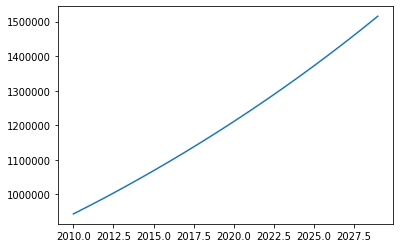

In [264]:
plt.plot(list(range(2010,2030) ), [ hf.GTMuniPopulation(101,y) for y in range(2010,2030)] )
None

In [456]:
casesNotif

year  quarter  department  municipality
2012  1        1.0         101             56
                           102              2
                           103              3
                           106              8
                           107              2
                           108             34
                           109              3
                           110             37
                           113              2
                           114              3
                           115             23
                           116             10
                           117             12
               2.0         201              1
                           203              1
                           207              2
               3.0         301              1
                           304              2
                           305              1
                           306              1
                           311          

In [457]:
notifsRate = casesNotif.reset_index()\
.apply(lambda x: x["Cases Notified_value_m_quarterly"] / hf.GTMuniPopulation(x.municipality, x.year + (x.quarter-1)/4), 1).iloc[:,0]

In [458]:
notifsRate.index = casesNotif.index.copy()

In [459]:
notifsRate = notifsRate.rename("Case Notification Rate_value_m_quarterly")

In [460]:
notifsRate

year  quarter  department  municipality
2012  1        1.0         101             0.000057
                           102             0.000021
                           103             0.000042
                           106             0.000064
                           107             0.000028
                           108             0.000071
                           109             0.000044
                           110             0.000171
                           113             0.000044
                           114             0.000027
                           115             0.000044
                           116             0.000067
                           117             0.000070
               2.0         201             0.000044
                           203             0.000025
                           207             0.000169
               3.0         301             0.000021
                           304             0.000053
                        

In [372]:
# Mortality Rate_value
vrredis =  pd.read_csv("../../../Outcome Measurement Data/MULTI/VR/vr_redistributed_collapsed_diseases.csv", index_col = 0)

In [373]:
# munis_ids = pd.read_csv("../../Outcome Measurement Data/MULTI/VR/GTM_muni_merges_2009_2016_fixed.csv", index_col = 0)
munis_ids = pd.read_csv("../../../Covariates and Other Data/GIS/GTM_muni_merges_2009_2016_fixed.csv", index_col = 0)

In [374]:
vrredis = vrredis.merge(munis_ids[["adm2_country_code", "adm2_gbd_id"]], left_on= "location_id", right_on="adm2_gbd_id")

In [377]:
mortcounts = vrredis[vrredis.disease.isin(["TB", "TB-VIH"]) & (vrredis.adm2_country_code.notna())]\
.assign(municipality = lambda x: x.adm2_country_code.astype(int), year = lambda x: x.year_id,
        department = lambda x: np.floor(x.adm2_country_code/100).astype(int) ) \
.groupby(["year", "department", "municipality"]).deaths.sum().rename("mortcounts")

In [378]:
mortrate = mortcounts.reset_index().apply(lambda x: x["mortcounts"] / hf.GTMuniPopulation(x.municipality, x.year), 1).iloc[:,0]

In [379]:
mortrate.index = mortcounts.index.copy()

In [380]:
mortrate = mortrate.rename("Mortality Rate_value_m_yearly")

In [381]:
#  Treatment Success Rate_value
txsrate = pivot_cohortes["COMPLETED TREATMENT"].divide(pivot_cohortes.sum(1))\
.rename_axis(index={"deptocode": "department"}).rename("Treatment Success Rate_value_d_quarterly")

In [383]:
# HIV/TB Treatment Success Rate_value
pivot_cohortes_tbhiv = cohortes[(cohortes.quarter.notna()) & 
       (cohortes.table.isin([
           "Nuevos TB/VIH",  # year <= 2016
           "Nuevos Pulmonares TB/VIH Bact Conf", "Nuevos Pulmonares TB/VIH Dx Clinico" #2017
       ])) &
       (cohortes.deptocode!=0)].\
    groupby(["year", "quarter", "deptocode", "row_name_B"]).value.sum().unstack(3)
tbhiv_txsrate = pivot_cohortes_tbhiv["COMPLETED TREATMENT"].divide(pivot_cohortes_tbhiv.sum(1))\
.rename_axis(index={"deptocode": "department"}).rename("HIV/TB Treatment Success Rate_value_d_quarterly")

In [385]:
# HIV/TB Mortality Rate_value
tbhiv_mortrate = vrredis[vrredis.disease.isin(["TB", "TB-VIH"]) & (vrredis.adm2_country_code.notna())]\
.assign(municipality = lambda x: x.adm2_country_code.astype(int), year = lambda x: x.year_id,
        department = lambda x: np.floor(x.adm2_country_code/100).astype(int) ) \
.groupby(["year", "department", "municipality"]).deaths.sum().rename("HIV/TB Mortality Rate_value_m_yearly")

In [386]:
# MDR Treatment Success Rate_value
mdrtb.columns

Index(['Unnamed: 0', 'Age', 'BD_ID', 'DAS', 'DateBk_1', 'DateCulture_1',
       'DateCulture_10', 'DateCulture_11', 'DateCulture_12', 'DateCulture_13',
       'DateCulture_14', 'DateCulture_15', 'DateCulture_16', 'DateCulture_17',
       'DateCulture_18', 'DateCulture_19', 'DateCulture_2', 'DateCulture_20',
       'DateCulture_21', 'DateCulture_22', 'DateCulture_23', 'DateCulture_24',
       'DateCulture_3', 'DateCulture_4', 'DateCulture_5', 'DateCulture_6',
       'DateCulture_7', 'DateCulture_8', 'DateCulture_9', 'DateGXPERT', 'Dead',
       'Depto', 'DiabetesMel', 'DxDate', 'ExitCondition', 'ExitDate',
       'GENOTYPE', 'Gender', 'HIV', 'ID', 'Modifications', 'Muni',
       'Observations', 'PDSDate', 'PDSResult', 'PxCondition', 'PxLost',
       'PxNew', 'PxRelapse', 'Referred', 'ResistType', 'ResultBk_1',
       'ResultCulture_1', 'ResultCulture_10', 'ResultCulture_11',
       'ResultCulture_12', 'ResultCulture_13', 'ResultCulture_14',
       'ResultCulture_15', 'ResultCulture_16',

In [387]:
mdrtb.ExitCondition.value_counts(dropna=False)

NaN                           86
ambulatorio                   23
FALLECIDO                      7
PERDIDA EN EL SEGUIMIENTO      5
AMBULATORIO                    5
fallecido                      4
Fallecido                      4
FRACASO                        4
FALLECIDA                      3
TX. COMPLETO                   2
PÉRDIDA EN EL SEGUIMIENTO      2
vivo                           2
FUGADO                         2
ABANDONÓ                       1
Fallecida                      1
 EGRESO CONTRAINDICADO         1
viva                           1
Vivo                           1
CONTRAINDICADO                 1
FALLECIDA                      1
Fallecida                      1
Name: ExitCondition, dtype: int64

#### No hay datos confiables de cura de MDR ni de tratamiento completo.
El manual de tx a MDRs menciona que se considera curado a alguien que saca tres pruebas negativas consecutivas. Se puede tomar eso como un proxy de curados.

In [388]:
results = ["ResultCulture_" + str(i) for i in range(1,25)]

In [389]:
resultsdata = mdrtb[results].applymap(lambda x: str(x).lower())\
.applymap(lambda x: \
          "negativo" if "neg" in x else\
          "positivo" if ("pos" in x) or ("+" in x) else\
          "na" if ("cont" in x) or ("no " in x) or (x == "nan") or ("rehus" in x) or ("acid" in x) else x)

In [390]:
pd.unique(resultsdata.values.flatten())

array(['negativo', 'na', 'positivo', '2015-06-24 00:00:00', '1-19 col',
       'pr', '20 colonias', 'nr', '1-19 colonias', 'se verificará envio',
       'según pcte en hrr', '2017-06-21 00:00:00'], dtype=object)

In [391]:
mdrtb["mdrProbCured"] = resultsdata.apply(lambda x:"".join(x.values) , 1).apply(lambda x: x.replace("na", "").strip("-")[-24:] == "negativonegativonegativo")

In [392]:
mdrtb["mdrProbCured"].value_counts()

False    108
True      49
Name: mdrProbCured, dtype: int64

In [393]:
resultsdata.applymap(lambda x: \
          "n" if "negativo" == x else\
          "p" if x == "positivo" else "-").apply(lambda x: "".join(x.values), 1).head()

0    nnnn-n-n-n-n-n-nn--nnnnn
1    nnn--nnn--n-n-n------nn-
2    p-nnnnnn----nn-n--------
3    nnn-nnnnn-n--n-n----n---
4    nnn--nnn--n-n--p-------n
dtype: object

In [394]:
mdrtb.assign(TxYear = lambda x: x.TxDate_Year.astype(str)).groupby(["TxYear", "BD_ID"], observed=False).apply(len)

TxYear  BD_ID   
2009.0  MDR15-17     1
2014.0  MDR14-16    40
2015.0  MDR15-17    33
2016.0  MDR16-18    53
2017.0  MDR16-18     1
nan     MDR14-16     1
        MDR15-17     6
        MDR16-18    22
dtype: int64

In [395]:
mdrtb.BD_ID.value_counts(dropna=False)

MDR16-18    76
MDR14-16    41
MDR15-17    40
Name: BD_ID, dtype: int64

In [397]:
mdrcx = mdrtb.assign(year = lambda x: x.Year+2000).groupby(["year", "deptocode"]).mdrProbCured.apply(lambda x: x.sum() / len(x) if len(x)>0 else 0)\
.rename_axis(index={"deptocode": "department"}).rename("MDR Probably Cured_rate_d_yearly")

In [398]:
mdrcx

year  department
2014  1.0           0.571429
      2.0           1.000000
      5.0           0.615385
      9.0           0.000000
      10.0          0.600000
      11.0          0.000000
      12.0          0.875000
      13.0          1.000000
      17.0          0.000000
2015  1.0           0.250000
      5.0           0.111111
      9.0           0.333333
      10.0          0.333333
      11.0          0.500000
      12.0          0.666667
      13.0          0.250000
      15.0          0.000000
      18.0          0.500000
      21.0          0.000000
      22.0          0.000000
2016  1.0           0.250000
      3.0           0.000000
      5.0           0.214286
      7.0           0.000000
      8.0           0.000000
      9.0           0.000000
      10.0          0.333333
      11.0          0.000000
      12.0          0.086957
      13.0          0.000000
      14.0          0.000000
      16.0          0.000000
      17.0          0.000000
      18.0          0.3333

In [554]:
impact = pd.merge(makeFullIndex( notifsRate), makeFullIndex(mortrate), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(txsrate), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(tbhiv_txsrate), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(tbhiv_mortrate), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(mdrcx), left_index=True, right_index=True, how="outer")\
            

['year', 'quarter', 'department', 'municipality']
['year', 'department', 'municipality']
imputing quarter index level
['year', 'quarter', 'department']
['year', 'quarter', 'department']
['year', 'department', 'municipality']
imputing quarter index level
['year', 'department']
imputing quarter index level


In [555]:
impact.to_csv("../../../Impact Evaluation/TB/impact.csv")

# Outcomes

* Proportion of Cases Treated_value
* Proportion of Cases in Prisons Treated_value
* Proportion of HIV/TB Cases Treated_value
* Proportion of TB Patients who Received HIV Test_value
* ~~Proportion of New HIV Patients Starting IPT_value~~
* Proportion of MDR Cases Treated_value
* Proportion of Patients Receiving DST_value
* ~~Proportion of MDR Cases completing at least 6 mo of therapy_value~~

In [402]:
(initiatedTx / casesNotif.reset_index().groupby(["year", "department"])["Cases Notified_value_m_quarterly"].sum()).describe()

count    528.000000
mean       0.205219
std        0.077202
min        0.000000
25%        0.157120
50%        0.193471
75%        0.241148
max        0.550000
dtype: float64

In [403]:
# FechaInicioTx <= 4 indica fechas inválidas o no disponibles
notifs.FECHAINICIOTX[notifs.FECHAINICIOTX.map(lambda x: len(str(x))<=4)].unique()

array(['ND', 'nd', nan, 'NR', '…', '….', 'MD', 'NRND', 'NE', 'N'],
      dtype=object)

In [410]:
initTxNotifs = notifs[ notifs.FECHAINICIOTX.map(lambda x: len(str(x))<=4) &
                     (notifs.Year<=2018) & 
                     notifs.COD_MUNI.notna()]\
        .assign(department = lambda x: (np.floor(x.municipality/100)).astype(int) )\
        .groupby(["year", "quarter", "department", "municipality"]).apply(len)

In [413]:
propCasesTx =  (initTxNotifs / casesNotif).rename("Proportion of Cases Treated_value_m_quarterly")

In [463]:
ppltx_yearly = ppltx.groupby([
    ppltx.index.get_level_values("year"), 
    ppltx.index.get_level_values("department"),
    ppltx.index.get_level_values("municipality")]).sum()

In [542]:
# Proportion of Cases in Prisons Treated_value
propPPLTx = (ppltx_yearly / pplcases).rename("Proportion of Cases in Prisons Treated_value_d_yearly")

In [543]:
propPPLTx[propPPLTx.notna()].head()

year  department  municipality  quarter
2014  1           101           1          1.0
                                2          1.0
                                3          1.0
                                4          1.0
                  113           1          1.0
Name: Proportion of Cases in Prisons Treated_value_d_yearly, dtype: float64

In [544]:
propPPLTx.index = propPPLTx.index.reorder_levels(["year",  "quarter",  "department",  "municipality"], )

In [545]:
propPPLTx.head()

year  quarter  department  municipality
2014  1        1           101             1.0
      2        1           101             1.0
      3        1           101             1.0
      4        1           101             1.0
      1        1           102             NaN
Name: Proportion of Cases in Prisons Treated_value_d_yearly, dtype: float64

In [517]:
# Proportion of HIV/TB Cases Treated_value
temp = notifs[(notifs.FECHAINICIOTX.map(lambda x: len(str(x))<=4)) & (notifs.VIH == "Reactive") & (notifs.Year<=2018) & notifs.COD_MUNI.notna()]\
.groupby(["year", "quarter", "department", "municipality"]).apply(len)

propHIVTx = (temp / hivcases).rename("Proportion of HIV/TB Cases Treated_value_m_quarterly")

In [520]:
propHIVTx.head()

year  quarter  department  municipality
2012  1        1           101             NaN
                           107             1.0
                           108             0.5
                           110             NaN
                           113             1.0
Name: Proportion of HIV/TB Cases Treated_value_m_quarterly, dtype: float64

In [518]:
# Proportion of TB Patients who Received HIV Test_value
propTbHivDx = (tbhivTx / casesNotif).rename("Proportion of TB Patients who Received HIV Test_value_m_quarterly")

In [519]:
propTbHivDx[propTbHivDx.notna()].head()

year  quarter  department  municipality
2013  2        1           101             0.623932
                           107             0.571429
                           108             0.034483
                           110             0.032258
                           115             0.111111
Name: Proportion of TB Patients who Received HIV Test_value_m_quarterly, dtype: float64

In [521]:
propHivIPT = \
sicoinRM[(sicoinRM.Programa == "16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA") &
sicoinRM.Resultado.isin(
       ['6.0-Paciente VIH positivo, con prueba diagnóstica de tuberculosis',
       '6.0-Pacientes VIH positivos, con prueba diagnostica de Tuberculosis']
) & (sicoinRM.LugarEjecutado.notna())].assign(year = lambda x: x.Year, quarter = lambda x: x.Trimestre, municipality = lambda x: x.LugarCod.map(int))\
.assign(department = lambda x: np.floor(x.municipality/100).astype(int) )\
.groupby(["year", "quarter", "department", "municipality"]).LugarEjecutado.sum()\
.rename("PLHIV Screened for TB_value_m_quarterly")


In [522]:
propHivIPT.head()

year  quarter  department  municipality
2013  2        1           110              3.0
                           113              1.0
               7           708             11.0
               8           803              1.0
                           805              1.0
Name: PLHIV Screened for TB_value_m_quarterly, dtype: float64

In [523]:
# Proportion of New HIV Patients Starting IPT_value
# HIV with IPT :  plhivipt

In [524]:
sicoinRM[(sicoinRM.Programa == "16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA") &
        sicoinRM.Resultado.isin([      '8.0-Paciente VIH positivo con tratamiento ARV'
                                 #'1.0-Persona con diagnóstico y tratamiento de ITS, VIH/SIDA'
                                ]) &
        sicoinRM.LugarCod.isna()]

,Unnamed: 0,Programa,Subprograma,Proyecto,ActOb,Resultado,LugarCod,LocationNombre,Unidades,Inicial,Vigente,LugarEjecutado,Ejecutado,PorcEj,NBeneficiados,Year,Reporte_Programa,Trimestre
5842,5842,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,64629.0,NaN,46995.0,72.72,0.0,2017,"ENTIDAD = 11130009, PROGRAMA = 16",3
12360,12360,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,64629.0,NaN,457.0,0.71,0.0,2017,"ENTIDAD = 11130009, PROGRAMA = 16",2
14813,14813,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,73132.0,NaN,15752.0,21.54,0.0,2018,"ENTIDAD = 11130009, PROGRAMA = 16",4
21425,21425,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,73132.0,NaN,874.0,1.20,0.0,2018,"ENTIDAD = 11130009, PROGRAMA = 16",1
26147,26147,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,64629.0,NaN,237.0,0.37,0.0,2017,"ENTIDAD = 11130009, PROGRAMA = 16",1
29013,29013,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,64629.0,NaN,499.0,0.77,0.0,2017,"ENTIDAD = 11130009, PROGRAMA = 16",4
33476,33476,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,73132.0,NaN,42672.0,58.35,0.0,2018,"ENTIDAD = 11130009, PROGRAMA = 16",3
39613,39613,"16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA",00-SIN SUBPROGRAMA,000-SIN PROYECTO,002-000-PERSONA CON DIAGNÓSTICO Y TRATAMIENTO ...,8.0-Paciente VIH positivo con tratamiento ARV,NaN,Paciente VIH positivo con tratamiento ARV,Persona,70496.0,73132.0,NaN,1365.0,1.87,0.0,2018,"ENTIDAD = 11130009, PROGRAMA = 16",2


In [251]:
# There is no data on how many new HIV cases have been found
# sicoinRM[(sicoinRM.Programa == "16-PREVENCIÓN Y CONTROL DE ITS, VIH/SIDA")].Resultado.unique()

In [525]:
# Proportion of MDR Cases Treated_value
propMDRTx = ( mdrtx/mdrcases).rename("Proportion of MDR Cases Treated_value_d_yearly")

In [547]:
propMDRTx.index = propMDRTx.index.reorder_levels(["year",  "quarter",  "department",  "municipality"])

In [548]:
propMDRTx.head()

year  quarter  department  municipality
2014  1        1           101             0.857143
                           102             0.857143
                           103             0.857143
                           104             0.857143
                           105             0.857143
Name: Proportion of MDR Cases Treated_value_d_yearly, dtype: float64

In [526]:
# Proportion of Patients Receiving DST_value
notifs.columns.values

array(['NOMBRES', 'DIRECCION', 'MUNICIPIO', 'DEPARTAMENTO',
       'SERVICIODESALUD', 'SEXO', 'EDAD', 'RANGOEDAD', 'PESOLBS',
       'PESOKG', 'CONDICIONINGRESO', 'FECHANOTIFICACION', 'FECHAINICIOTX',
       'CLASIFICACION', 'VIH', 'ESQUEMA', 'CONTACTOS', 'OTRASPATOLOGIAS',
       'YEAR', 'YearMonth', 'TIPODETBPEDIATRICOS', 'FECHAPRUEBAVIH',
       'CONDICIONEGRESO', 'FECHAMUERTE', 'CAUSADEMUERTE',
       'PACIENTEPRIVADOLIBERTAD', 'DEPORTADO', 'LOCALIZACIONTB',
       'METODODX', 'CONTACTO_000_014', 'CONTACTO_MAYORA_015',
       'CASOINDICE', 'DESARROLLOTBCLASIFICACION', 'EMPLEADOMSPAS',
       'UNIDADDX', 'FALLECIDOS', 'CORRELATIVO', 'DAS', 'FECHANACIMIENTO',
       'FECHAACTUAL', 'EDADDECADA', 'EDUCACION', 'PUEBLO', 'OCUPACION',
       'NUEVACONDICIONINGRESO', 'FECHADX', 'NUEVOMETODODX', 'PDS',
       'CONTACTO_000_0004', 'CONTACTO_MAYORA_005', 'QUIMIO_VIH',
       'DBCATEGORY', 'DISTRITO', 'MIGRACION', 'CONDICIONPX',
       'CAUSAMUERTE', 'TipoTB', 'MESNOTIFICACION', 'OTRASPATOLOGI

In [527]:
casespds = notifs[ (notifs.FECHAPDS.map(lambda x: len(str(x))>4) | notifs.PDS.notna() | notifs.RESULTADOPDS.notna()) & 
        (notifs.Year<=2018) & notifs.COD_MUNI.notna()
      ].groupby(["year", "quarter", "department", "municipality"]).apply(len)

In [528]:
notifs.PDS.value_counts()

SI                     382
SENSIBLE               117
RESISTENTE INH          12
CONTAMINADO              6
RR                       4
RESISTENTE R             4
RESISTENTE INH,R         3
MDR                      2
ACIDIFICADA              1
REISTENTE A R            1
ACIDIFICADO              1
ND                       1
MONORESISTE A INH        1
NO CRECIO                1
RESISTENTE INH, STR      1
Name: PDS, dtype: int64

In [529]:
casespds.sum()

649

In [530]:
propDST = (casespds/casesNotif).fillna(0).rename("Proportion of Patients Receiving DST_value_m_quarterly")

In [532]:
propDST[propDST > 0]

year  quarter  department  municipality
2016  1        1           101             0.050000
                           107             1.000000
                           116             0.111111
               5           501             0.090909
                           502             0.111111
                           505             0.250000
                           506             0.100000
                           507             0.071429
                           509             0.111111
               7           705             0.142857
               9           901             0.500000
                           920             0.066667
               10          1001            0.125000
                           1010            0.142857
                           1011            1.000000
                           1013            0.071429
                           1014            0.071429
               11          1101            0.210526
                        

In [258]:
# Proportion of MDR Cases completing at least 6 mo of therapy_value

In [259]:
# There is no information about Tx duration

In [536]:
propPPLTx.head()

year  department  municipality  quarter
2014  1           101           1          1.0
                                2          1.0
                                3          1.0
                                4          1.0
                  102           1          NaN
Name: Proportion of Cases in Prisons Treated_value_d_yearly, dtype: float64

In [551]:
outcomes = pd.merge(makeFullIndex(propCasesTx), makeFullIndex(propPPLTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(propHIVTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(propTbHivDx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(propMDRTx), left_index=True, right_index=True, how="outer")\
            .merge(makeFullIndex(propDST), left_index=True, right_index=True, how="outer")\
            

['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']
['year', 'quarter', 'department', 'municipality']


In [553]:
outcomes.to_csv("../../../Impact Evaluation/TB/outcomes.csv")